# Language processing with NLTK

This notebooks shows some basic language processing concepts and approaches using the python NLTK library. You can view this as the most basic example approach.

Concepts i'm showing explain how to process text. Text processing with machine learning is a bit special, because machine learning algorithms only work on fixed-size vectors of numbers and text is a variable length of words. Also the words in the text are organized in sentences and separated by puntuation and other symbols.

In this notebook i'll show how to deal with that by:
- Preprocessing ("cleaning") the text
- Vectorizing the text to fixed-size vectors
- Classifying sentiment with a Naive Bayes Classifier

In [1]:
import pandas as pd

df = pd.read_csv('data/airline_sentiment.csv', index_col=0)

pd.set_option('max_colwidth', 140)

df[['airline_sentiment', 'text']].head()

,airline_sentiment,text
_unit_id,,
681448150,neutral,@VirginAmerica What @dhepburn said.
681448153,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
681448156,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
681448158,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
681448159,negative,@VirginAmerica and it's a really big bad thing about it


Above you can see the first lines of the loaded data. For each tweet we have the sentiment and the text. The sentiment means if this tweet was a positive one, a neutral one or negative.

Overall what we'll try to do in this notebook is predict the sentiment value from the text.

First step is preprocessing, we'll clean up the text by removing punctuation, lowercasing and splitting into words.

In [2]:
import nltk

tweets = df['text'].astype(str).map(lambda txt: [tok.strip('!,.') for tok in txt.lower().split()]).values
sentiments = df['airline_sentiment'].values

So let's check what this did. I'll print the tweet and the tokenized version. What you will see that the tweet has been split into separate words, it's become a list of words basically:

In [5]:
print(df['text'].values[1])
print(tweets[1])

@VirginAmerica plus you've added commercials to the experience... tacky.
['@virginamerica', 'plus', "you've", 'added', 'commercials', 'to', 'the', 'experience', 'tacky']


Now that our text has been tokenized, we can start on creating feature vectors for the machine learning. The way we'll do this, is to represent each tweet by a vector of true/false values indicating which words were present in the tweet.

First off, we need to know all the words that exist in this data:

In [6]:
all_words = list()
for words in tweets:
    all_words.extend(words)
    
word_dist = nltk.FreqDist(all_words)

Let's make a quick plot and see what words were found and how often they appear. What you'll see is a few very frequent words - and then a long tail of less frequent words.

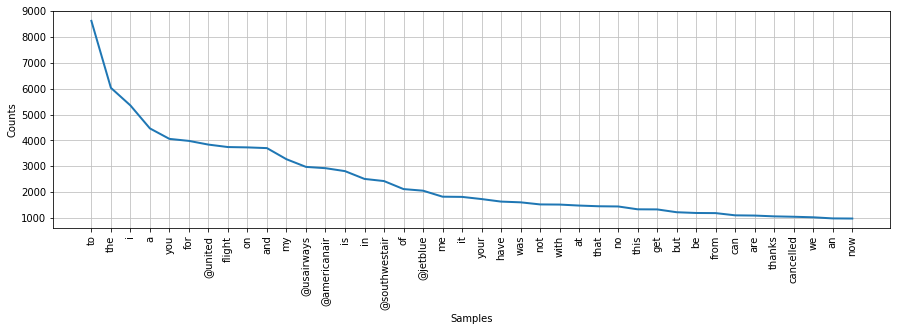

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 4))

word_dist.plot(40)

Next thing, we define our feature function. This function will transform a single tweet to a list of true/false values for each word indicating if that was present in the tweet.

In [8]:
def feature_function(doc, top_n=1000):
    document_words = set(doc)
    return {
        word : (word in document_words)
        for word, _ in word_dist.most_common(top_n)
    }

Next an example of how this looks, for the first few tweets. Note i'm only showing the first 15 entries of the feature vector! What you can see is, the feature function basically generates a large table of True/False values indicating which words are(n't) present in each tweet.

In [9]:
import pandas
pandas.DataFrame([feature_function(tweet, top_n=15) for tweet in tweets[:10]])

,@americanair,@united,@usairways,a,and,flight,for,i,in,is,my,on,the,to,you
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
4,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False
5,False,False,False,True,False,True,True,False,False,False,False,False,True,False,False
6,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
7,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
9,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False


This is the data the machine learning algorithm will learn and predict sentiment from. True/False (or 0/1) values indicating presence of words.

Next order of business, we apply the above feature function to all tweets!

In [10]:
processed_data = list(nltk.classify.util.apply_features(feature_function, list(zip(tweets, sentiments)), True))

Now comes a part that's important to understand in machine learning: Splitting data into the training and the test set.

When training a machine learning algorithm, you're learning patterns from the data you're feeding it. When you've trained the algorithm you want to know how good (or bad) it does on new data, data that it hasn't been trained on yet. This is called evaluating. It's important to do that with new, unseen data, else you might learn patterns that only work on the training data.

So the correct way to do this is to train on one part of data and then evaluate on another part. It's common to split the available data 80%/20% for example or 75%/25%.

In [11]:
import random

random.shuffle(processed_data)

split_at = int(len(processed_data) * 0.75)
train_set, test_set = processed_data[split_at:], processed_data[:split_at]

So now we have preprocessed, vectorized and split up the data, we are ready to train a classifier and see if we can predict the sentiment!

In [12]:
classifier = nltk.classify.NaiveBayesClassifier.train(train_set)

Classifier is trained, so how well does it work?!

In [13]:
print('%.2f' % nltk.classify.accuracy(classifier, test_set))

0.75


So we managed to achieve 75% accuracy with this simple sentiment analysis approach. That's not that bad - considering humans agree around 80% of the time. Let's look at some other metrics also.

In [14]:
from nltk.metrics import ConfusionMatrix

test_feats = [feats for (feats, label) in test_set]
test_labels = [label for (feats, label) in test_set]

predictions = classifier.classify_many(test_feats)

cm = ConfusionMatrix(test_labels, predictions)
print(cm.pretty_format())

         |    n         p |
         |    e    n    o |
         |    g    e    s |
         |    a    u    i |
         |    t    t    t |
         |    i    r    i |
         |    v    a    v |
         |    e    l    e |
---------+----------------+
negative |<5694> 772  373 |
 neutral |  643<1413> 283 |
positive |  318  322<1162>|
---------+----------------+
(row = reference; col = test)



Final thing i want to show here, which features or words were most important in predicting the sentiment. Of course you assume works like *thanks* or *good* to indicate positive and unfriendly words to indicate negative. Let's check!

In [15]:
classifier.show_most_informative_features(20)

Most Informative Features
                      :) = True           positi : negati =     62.5 : 1.0
                 awesome = True           positi : negati =     35.8 : 1.0
                 amazing = True           positi : negati =     29.1 : 1.0
                   thank = True           positi : negati =     23.9 : 1.0
                    hour = True           negati : neutra =     23.7 : 1.0
                   hours = True           negati : positi =     22.5 : 1.0
                   great = True           positi : neutra =     19.9 : 1.0
               excellent = True           positi : negati =     15.3 : 1.0
                 worries = True           positi : negati =     15.3 : 1.0
                 atlanta = True           neutra : negati =     13.3 : 1.0
              appreciate = True           positi : neutra =     13.1 : 1.0
                     ceo = True           neutra : negati =     12.9 : 1.0
                 minutes = True           negati : neutra =     12.9 : 1.0

So concluding, we've seen a basic approach of text processing with machine learning and explained some concepts.

I hope you enjoyed!